In [2]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.6 MB/s eta 0:00:00


Train a basic GNN model and visualize learned node embeddings.
Practical implementation using PyTorch Geometric and the Cora dataset.

Epoch: 010, Loss: 1.8403, Train Acc: 0.8786, Test Acc: 0.7020
Epoch: 020, Loss: 1.1879, Train Acc: 0.9786, Test Acc: 0.7630
Epoch: 030, Loss: 0.5340, Train Acc: 0.9857, Test Acc: 0.7920
Epoch: 040, Loss: 0.1872, Train Acc: 1.0000, Test Acc: 0.8080
Epoch: 050, Loss: 0.1035, Train Acc: 1.0000, Test Acc: 0.7850
Epoch: 060, Loss: 0.0435, Train Acc: 1.0000, Test Acc: 0.8060
Epoch: 070, Loss: 0.0287, Train Acc: 1.0000, Test Acc: 0.7970
Epoch: 080, Loss: 0.0309, Train Acc: 1.0000, Test Acc: 0.8030
Epoch: 090, Loss: 0.0238, Train Acc: 1.0000, Test Acc: 0.7990
Epoch: 100, Loss: 0.0181, Train Acc: 1.0000, Test Acc: 0.7980
Best Test Accuracy: 0.8120


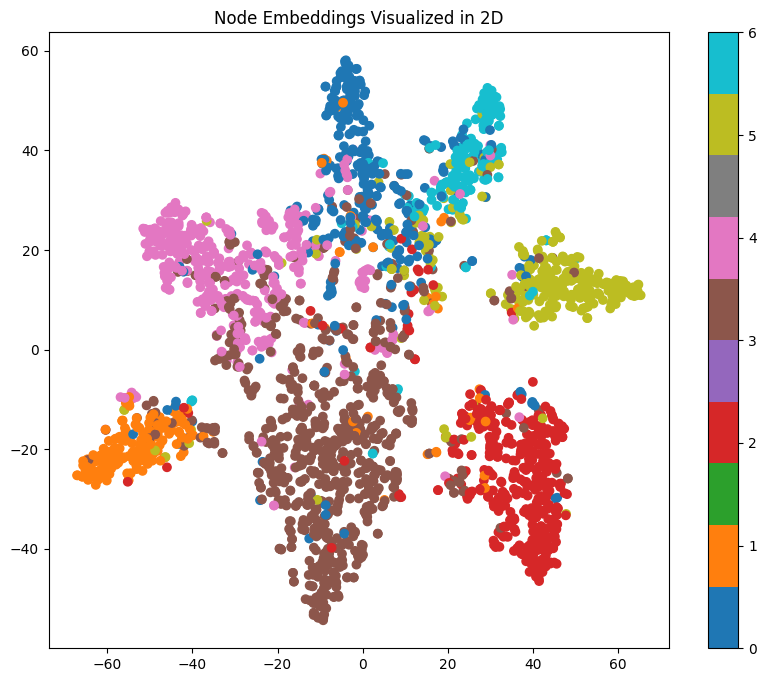

In [5]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
from torch.nn import Linear
import torch.nn as nn
from torch_geometric.transforms import NormalizeFeatures

# Load the Cora dataset
dataset = Planetoid(root='data/Cora', name='Cora', transform=NormalizeFeatures())
data = dataset[0]

# GNN model
class GNN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super().__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.out = Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        # First Graph Convolution Layer
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)

        # Second Graph Convolution Layer
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)

        # Output layer
        x = self.out(x)
        return F.log_softmax(x, dim=1)

# init
model = GNN(num_features=dataset.num_features,
            hidden_channels=64,
            num_classes=dataset.num_classes)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# train function
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss

# eval function
@torch.no_grad()
def test():
    model.eval()
    out = model(data.x, data.edge_index)

    # Training accuracy
    pred = out.argmax(dim=1)
    train_correct = pred[data.train_mask] == data.y[data.train_mask]
    train_acc = int(train_correct.sum()) / int(data.train_mask.sum())

    # Test accuracy
    test_correct = pred[data.test_mask] == data.y[data.test_mask]
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())

    return train_acc, test_acc

# loop
best_test_acc = 0
for epoch in range(1, 101):
    loss = train()
    train_acc, test_acc = test()
    if test_acc > best_test_acc:
        best_test_acc = test_acc

    if epoch % 10 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

print(f'Best Test Accuracy: {best_test_acc:.4f}')

# Visualize learned NODE embeddings
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

@torch.no_grad()
def visualize_embeddings():
    model.eval()
    # Get embeddings from the second-to-last layer
    embeddings = model.conv2(
        model.conv1(data.x, data.edge_index).relu(),
        data.edge_index
    ).cpu().numpy()

    # Reduce dimensionality for visualization
    tsne = TSNE(n_components=2, random_state=42)
    node_embeddings_2d = tsne.fit_transform(embeddings)

    # Plot
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(node_embeddings_2d[:, 0], node_embeddings_2d[:, 1],
                         c=data.y.cpu().numpy(), cmap='tab10')
    plt.colorbar(scatter)
    plt.title('Node Embeddings Visualized in 2D')
    plt.show()

visualize_embeddings()

Advanced Implementation - Practical implementation using PyTorch Geometric and the Cora dataset.


Training GCN...
Epoch: 010, Loss: 1.8287, Train Acc: 0.8143, Test Acc: 0.5130
Epoch: 020, Loss: 1.1825, Train Acc: 0.9786, Test Acc: 0.8000
Epoch: 030, Loss: 0.3997, Train Acc: 0.9857, Test Acc: 0.7950
Epoch: 040, Loss: 0.1281, Train Acc: 0.9857, Test Acc: 0.7710
Epoch: 050, Loss: 0.0858, Train Acc: 1.0000, Test Acc: 0.7930
Epoch: 060, Loss: 0.0250, Train Acc: 1.0000, Test Acc: 0.7850
Epoch: 070, Loss: 0.0143, Train Acc: 1.0000, Test Acc: 0.7870
Epoch: 080, Loss: 0.0135, Train Acc: 1.0000, Test Acc: 0.7930
Epoch: 090, Loss: 0.0082, Train Acc: 1.0000, Test Acc: 0.7860
Epoch: 100, Loss: 0.0242, Train Acc: 1.0000, Test Acc: 0.7910
Epoch: 110, Loss: 0.0083, Train Acc: 1.0000, Test Acc: 0.7860
Epoch: 120, Loss: 0.0036, Train Acc: 1.0000, Test Acc: 0.7770
Epoch: 130, Loss: 0.0113, Train Acc: 1.0000, Test Acc: 0.7790
Epoch: 140, Loss: 0.0150, Train Acc: 1.0000, Test Acc: 0.7860
Epoch: 150, Loss: 0.0060, Train Acc: 1.0000, Test Acc: 0.7780
Epoch: 160, Loss: 0.0045, Train Acc: 1.0000, Test Acc

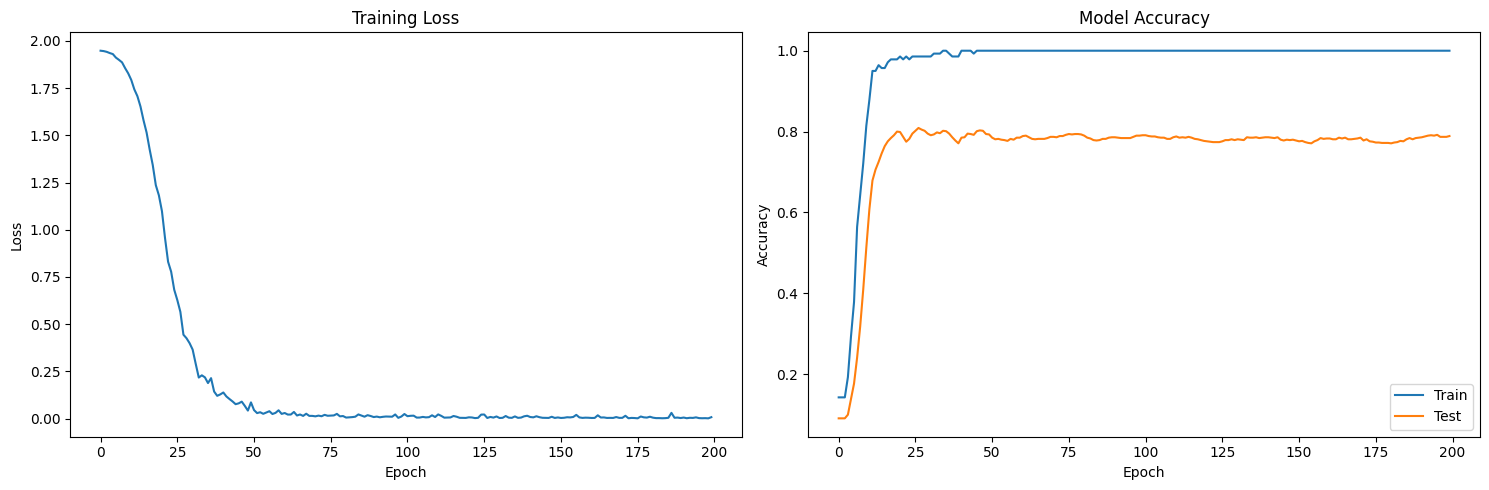

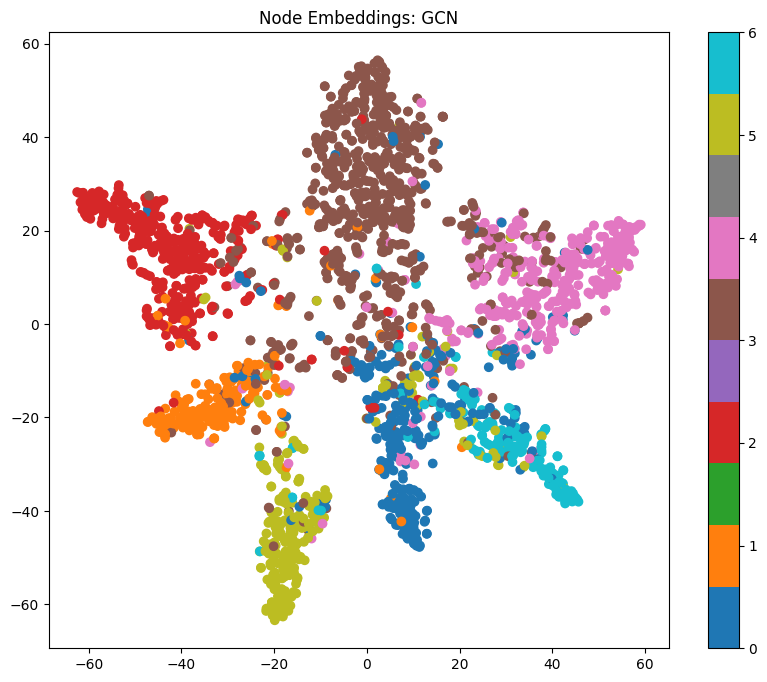


Training GAT...
Epoch: 010, Loss: 0.5637, Train Acc: 0.9786, Test Acc: 0.7810
Epoch: 020, Loss: 0.0157, Train Acc: 1.0000, Test Acc: 0.7970
Epoch: 030, Loss: 0.0036, Train Acc: 1.0000, Test Acc: 0.7750
Epoch: 040, Loss: 0.0002, Train Acc: 1.0000, Test Acc: 0.7690
Epoch: 050, Loss: 0.0004, Train Acc: 1.0000, Test Acc: 0.7590
Epoch: 060, Loss: 0.0011, Train Acc: 1.0000, Test Acc: 0.7720
Epoch: 070, Loss: 0.0002, Train Acc: 1.0000, Test Acc: 0.7970
Epoch: 080, Loss: 0.0002, Train Acc: 1.0000, Test Acc: 0.7460
Epoch: 090, Loss: 0.0047, Train Acc: 1.0000, Test Acc: 0.7230
Epoch: 100, Loss: 0.0005, Train Acc: 1.0000, Test Acc: 0.7390
Epoch: 110, Loss: 0.0005, Train Acc: 1.0000, Test Acc: 0.7690
Epoch: 120, Loss: 0.0003, Train Acc: 1.0000, Test Acc: 0.7690
Epoch: 130, Loss: 0.0010, Train Acc: 1.0000, Test Acc: 0.7700
Epoch: 140, Loss: 0.0014, Train Acc: 1.0000, Test Acc: 0.7590
Epoch: 150, Loss: 0.0001, Train Acc: 1.0000, Test Acc: 0.7530
Epoch: 160, Loss: 0.0004, Train Acc: 1.0000, Test Acc

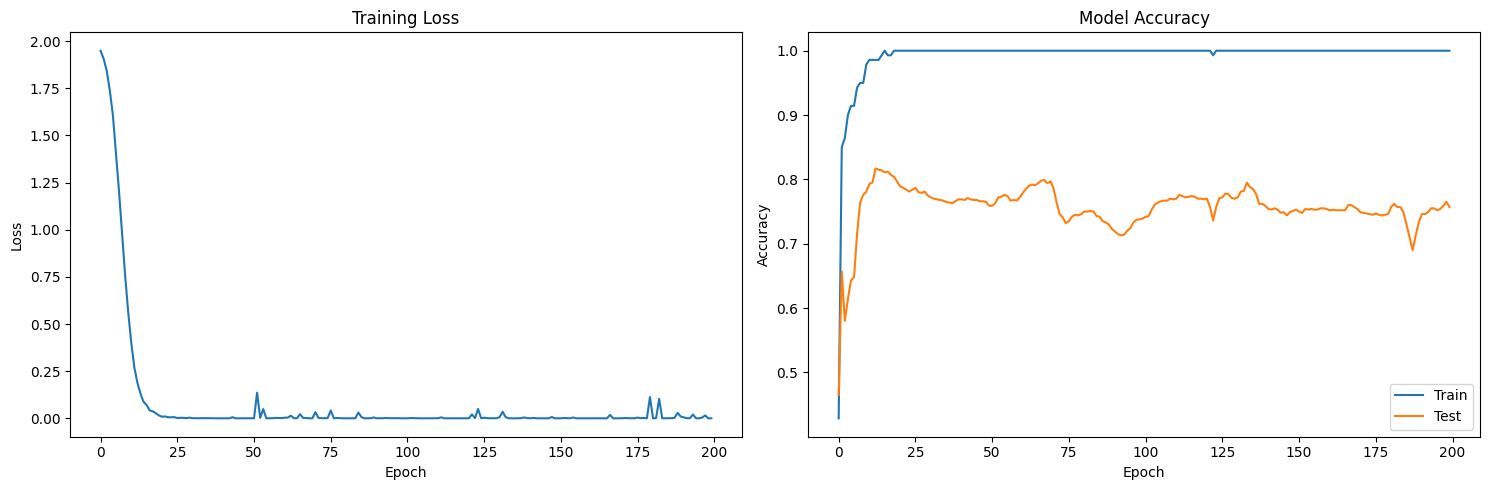

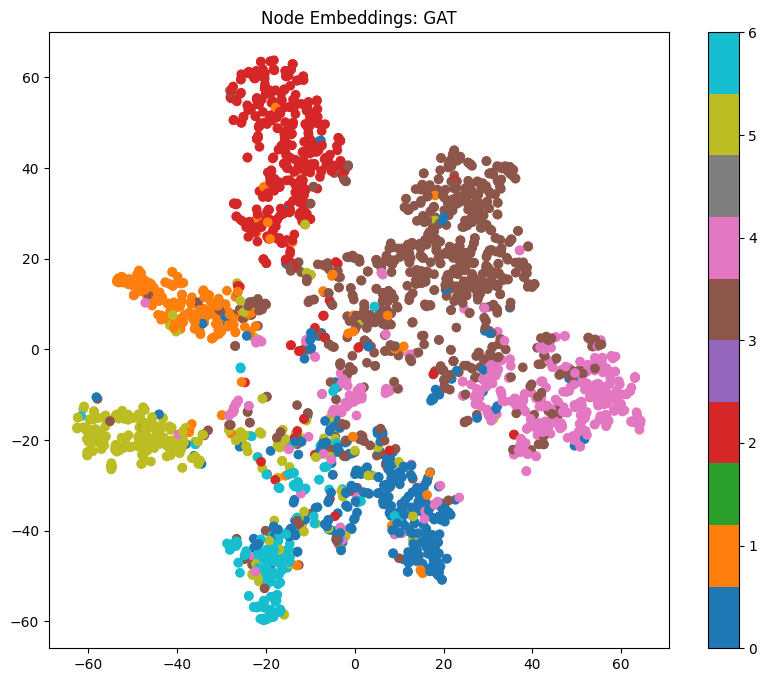


Training GraphSAGE...
Epoch: 010, Loss: 1.6850, Train Acc: 0.8429, Test Acc: 0.5140
Epoch: 020, Loss: 0.6370, Train Acc: 0.9857, Test Acc: 0.7530
Epoch: 030, Loss: 0.1325, Train Acc: 1.0000, Test Acc: 0.7730
Epoch: 040, Loss: 0.0504, Train Acc: 1.0000, Test Acc: 0.7890
Epoch: 050, Loss: 0.0136, Train Acc: 1.0000, Test Acc: 0.7960
Epoch: 060, Loss: 0.0243, Train Acc: 1.0000, Test Acc: 0.7990
Epoch: 070, Loss: 0.0128, Train Acc: 1.0000, Test Acc: 0.7910
Epoch: 080, Loss: 0.0089, Train Acc: 1.0000, Test Acc: 0.7960
Epoch: 090, Loss: 0.0317, Train Acc: 1.0000, Test Acc: 0.7980
Epoch: 100, Loss: 0.0027, Train Acc: 1.0000, Test Acc: 0.7960
Epoch: 110, Loss: 0.0024, Train Acc: 1.0000, Test Acc: 0.7830
Epoch: 120, Loss: 0.0018, Train Acc: 1.0000, Test Acc: 0.7820
Epoch: 130, Loss: 0.0044, Train Acc: 1.0000, Test Acc: 0.7960
Epoch: 140, Loss: 0.0240, Train Acc: 1.0000, Test Acc: 0.7950
Epoch: 150, Loss: 0.0078, Train Acc: 1.0000, Test Acc: 0.7900
Epoch: 160, Loss: 0.0054, Train Acc: 1.0000, Te

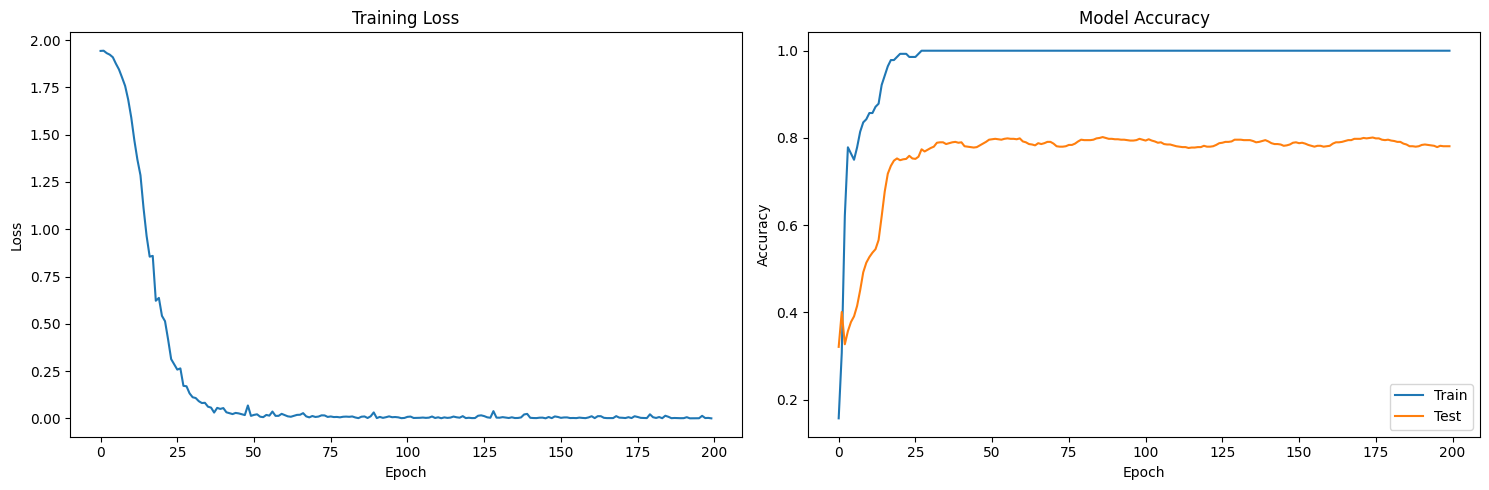

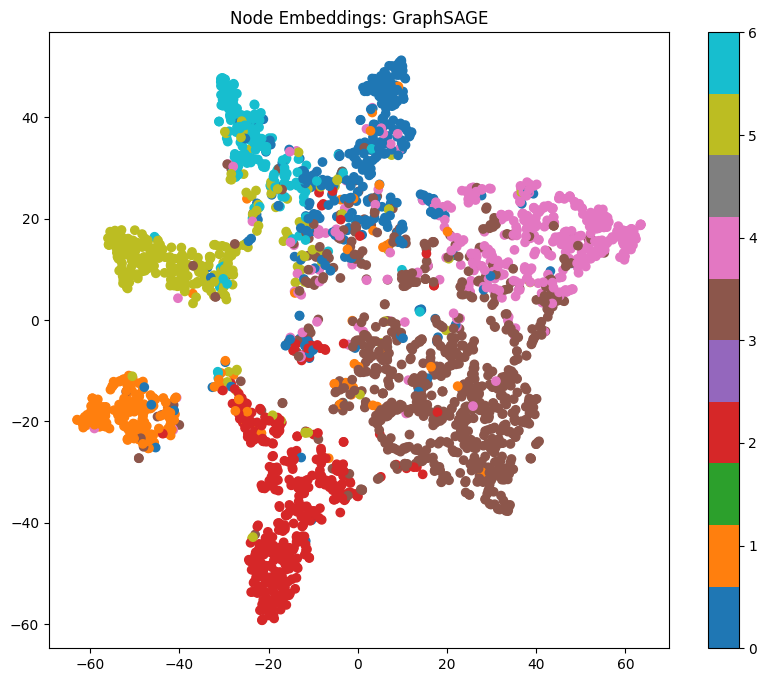


Final Results:
GCN: Best Test Accuracy = 0.8090
GAT: Best Test Accuracy = 0.8170
GraphSAGE: Best Test Accuracy = 0.8020


In [6]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv, GATConv, SAGEConv
from torch.nn import Linear
import torch.nn as nn
from torch_geometric.transforms import NormalizeFeatures
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import numpy as np

# Load the Cora dataset
dataset = Planetoid(root='data/Cora', name='Cora', transform=NormalizeFeatures())
data = dataset[0]

# Base GNN class with common functionality
class BaseGNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.dropout = 0.5

    def training_step(self, data):
        self.train()
        out = self(data.x, data.edge_index)
        loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
        return loss

    def get_embeddings(self, data):
        self.eval()
        with torch.no_grad():
            return self.get_intermediate_embeddings(data.x, data.edge_index)

# GCN Implementation
class GCN(BaseGNN):
    def __init__(self, num_features, hidden_channels, num_classes):
        super().__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.out = Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.out(x)
        return F.log_softmax(x, dim=1)

    def get_intermediate_embeddings(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

# GAT Implementation
class GAT(BaseGNN):
    def __init__(self, num_features, hidden_channels, num_classes, heads=8):
        super().__init__()
        self.conv1 = GATConv(num_features, hidden_channels, heads=heads)
        self.conv2 = GATConv(hidden_channels * heads, hidden_channels, heads=1)
        self.out = Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.out(x)
        return F.log_softmax(x, dim=1)

    def get_intermediate_embeddings(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = self.conv2(x, edge_index)
        return x

# GraphSAGE Implementation
class GraphSAGE(BaseGNN):
    def __init__(self, num_features, hidden_channels, num_classes):
        super().__init__()
        self.conv1 = SAGEConv(num_features, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.out = Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.out(x)
        return F.log_softmax(x, dim=1)

    def get_intermediate_embeddings(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Training and Evaluation Class
class ModelTrainer:
    def __init__(self, model, optimizer, data):
        self.model = model
        self.optimizer = optimizer
        self.data = data
        self.train_accuracies = []
        self.test_accuracies = []
        self.losses = []

    def train_epoch(self):
        self.optimizer.zero_grad()
        loss = self.model.training_step(self.data)
        loss.backward()
        self.optimizer.step()
        return loss.item()

    @torch.no_grad()
    def evaluate(self):
        self.model.eval()
        out = self.model(self.data.x, self.data.edge_index)
        pred = out.argmax(dim=1)

        train_acc = (pred[self.data.train_mask] == self.data.y[self.data.train_mask]).float().mean()
        test_acc = (pred[self.data.test_mask] == self.data.y[self.data.test_mask]).float().mean()

        return train_acc.item(), test_acc.item()

    def train(self, epochs):
        best_test_acc = 0

        for epoch in range(1, epochs + 1):
            loss = self.train_epoch()
            train_acc, test_acc = self.evaluate()

            self.losses.append(loss)
            self.train_accuracies.append(train_acc)
            self.test_accuracies.append(test_acc)

            if test_acc > best_test_acc:
                best_test_acc = test_acc

            if epoch % 10 == 0:
                print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, '
                      f'Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

        return best_test_acc

# Visualization functions
def plot_training_curves(trainer):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Loss curve
    ax1.plot(trainer.losses)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training Loss')

    # Accuracy curves
    ax2.plot(trainer.train_accuracies, label='Train')
    ax2.plot(trainer.test_accuracies, label='Test')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Model Accuracy')
    ax2.legend()

    plt.tight_layout()
    plt.show()

def visualize_embeddings(model, data, title):
    embeddings = model.get_embeddings(data).cpu().numpy()
    tsne = TSNE(n_components=2, random_state=42)
    node_embeddings_2d = tsne.fit_transform(embeddings)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(node_embeddings_2d[:, 0], node_embeddings_2d[:, 1],
                         c=data.y.cpu().numpy(), cmap='tab10')
    plt.colorbar(scatter)
    plt.title(f'Node Embeddings: {title}')
    plt.show()

# Training and comparison
def train_and_compare_models(data):
    models = {
        'GCN': GCN(dataset.num_features, 64, dataset.num_classes),
        'GAT': GAT(dataset.num_features, 64, dataset.num_classes),
        'GraphSAGE': GraphSAGE(dataset.num_features, 64, dataset.num_classes)
    }

    results = {}

    for name, model in models.items():
        print(f"\nTraining {name}...")
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
        trainer = ModelTrainer(model, optimizer, data)
        best_acc = trainer.train(200)

        results[name] = {
            'best_acc': best_acc,
            'trainer': trainer,
            'model': model
        }

        # Plot training curves
        plot_training_curves(trainer)

        # Visualize embeddings
        visualize_embeddings(model, data, name)

    return results

# Run the comparison
results = train_and_compare_models(data)

# Print final results
print("\nFinal Results:")
for name, result in results.items():
    print(f"{name}: Best Test Accuracy = {result['best_acc']:.4f}")